In [1]:
# モジュールをインポート
import numpy as np
from numpy import random as rd
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
# 各惑星系におけるパラメータ及び必要な測光制度
fname = '/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper'
z = np.load('{}/Data/parameter_3000.npy'.format(fname))
R_star = np.load('{}/Data/radius.npy'.format(fname))*6.95508*10**10
R_planet = R_planet = 6.378137*10**8
P = np.load('{}/Data/period.npy'.format(fname))
a = np.load('{}/Data/semi.npy'.format(fname))
p = R_planet/R_star
t_exp = 60
P_tra = P*R_star/np.pi/a
t_one = (P_tra*3/t_exp).astype(np.int64)
e_h = 30*10**5
accuracy = 2*R_planet*e_h/R_star**2*10**6

# データの取得

In [3]:
# 各ピクセルの値を取得
D_sci = np.load('{}/Simulation/Primary/D_sci_1.npy'.format(fname))
D_back = np.load('{}/Simulation/Primary/D_back_1.npy'.format(fname))
D_ref = np.load('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Simulation/Primary/D_ref_1.npy')
for i in range(2, 5):
    D_sci = np.vstack((D_sci, np.load('{}/Simulation/Primary/D_sci_{}.npy'.format(fname, i))))
    D_back = np.vstack((D_back, np.load('{}/Simulation/Primary/D_back_{}.npy'.format(fname, i))))
    D_ref = np.vstack((D_ref, np.load('{}/Simulation/Primary/D_ref_{}.npy'.format(fname, i))))

In [4]:
# 波長のリストを取得
lamb = np.load('{}/Data/lamb.npy'.format(fname))
lamb_20 = np.load('{}/Data/lamb_20.npy'.format(fname))

In [5]:
# 規格化された各データを取得
mod_2500 = np.load('{}/Simulation/Primary/mod_norm_primary_2500.npy'.format(fname))
sci_2500 = np.load('{}/Simulation/Primary/sci_norm_primary_2500.npy'.format(fname))
sub_2500 = np.load('{}/Simulation/Primary/sub_norm_primary_2500.npy'.format(fname))
wop_2500 = np.load('{}/Simulation/Primary/wop_norm_primary_2500.npy'.format(fname))
mod_3000 = np.load('{}/Simulation/Primary/mod_norm_primary_3000.npy'.format(fname))
sci_3000 = np.load('{}/Simulation/Primary/sci_norm_primary_3000.npy'.format(fname))
sub_3000 = np.load('{}/Simulation/Primary/sub_norm_primary_3000.npy'.format(fname))
wop_3000 = np.load('{}/Simulation/Primary/wop_norm_primary_3000.npy'.format(fname))
mod_3500 = np.load('{}/Simulation/Primary/mod_norm_primary_3500.npy'.format(fname))
sci_3500 = np.load('{}/Simulation/Primary/sci_norm_primary_3500.npy'.format(fname))
sub_3500 = np.load('{}/Simulation/Primary/sub_norm_primary_3500.npy'.format(fname))
wop_3500 = np.load('{}/Simulation/Primary/wop_norm_primary_3500.npy'.format(fname))
mod_4000 = np.load('{}/Simulation/Primary/mod_norm_primary_4000.npy'.format(fname))
sci_4000 = np.load('{}/Simulation/Primary/sci_norm_primary_4000.npy'.format(fname))
sub_4000 = np.load('{}/Simulation/Primary/sub_norm_primary_4000.npy'.format(fname))
wop_4000 = np.load('{}/Simulation/Primary/wop_norm_primary_4000.npy'.format(fname))

In [23]:
# スペクトルデータと各評価値を取得
df_spectrum = pd.read_csv('{}/Data/primary_spectra.csv'.format(fname))

wog_eva = np.load('{}/Simulation/Primary/wog_evaluation_primary.npy'.format(fname))
wog_sig = np.load('{}/Simulation/Primary/wog_sigma_primary.npy'.format(fname))
sci_eva = np.load('{}/Simulation/Primary/sci_evaluation_primary.npy'.format(fname))
sci_sig = np.load('{}/Simulation/Primary/sci_sigma_primary.npy'.format(fname))
sub_eva = np.load('{}/Simulation/Primary/sub_evaluation_primary.npy'.format(fname))
sub_sig = np.load('{}/Simulation/Primary/sub_sigma_primary.npy'.format(fname))

# データの修正

In [24]:
# 各評価値をR=20に変換
def binning(data, R):
    i = int(100/R)
    new_data = np.array([[[0]*(int(len(lamb)/i)+1)]*4]*100, float)
    for ll in range(int(len(lamb)/i)+1):
        n = 0
        for jj in range(i):
            if len(lamb)<=ll*i+jj:
                break
            new_data[:, :, ll] += data[:, :, ll*i+jj]
            n += 1
        new_data[:, :, ll] /= n
    return new_data

wog_eva_20 = binning(wog_eva, 20)
wog_sig_20 = binning(wog_sig, 20)
sci_eva_20 = binning(sci_eva, 20)
sci_sig_20 = binning(sci_sig, 20)
sub_eva_20 = binning(sub_eva, 20)
sub_sig_20 = binning(sub_sig, 20)

In [25]:
# 30回分のtransit curveを一つの行に平滑化
def Flatten(sci, sub, wop):
    sci = [sci[ll].flatten() for ll in range(len(sci))]
    sub = [sub[ll].flatten() for ll in range(len(sub))]
    wop = [wop[ll].flatten() for ll in range(len(sub))]
    return sci, sub, wop

sci_flat_2500, sub_flat_2500, wop_flat_2500 = Flatten(sci_2500, sub_2500, wop_2500)
sci_flat_3000, sub_flat_3000, wop_flat_3000 = Flatten(sci_3000, sub_3000, wop_3000)
sci_flat_3500, sub_flat_3500, wop_flat_3500 = Flatten(sci_3500, sub_3500, wop_3500)
sci_flat_4000, sub_flat_4000, wop_flat_4000 = Flatten(sci_4000, sub_4000, wop_4000)

In [26]:
# 30回分のtransit curveをone transitに平均化
def Bin(sci, sub, wop):
    sci = np.mean(sci, axis=1)
    sub = np.mean(sub, axis=1)
    wop = np.mean(wop, axis=1)
    return sci, sub, wop

sci_bin_2500, sub_bin_2500, wop_bin_2500 = Bin(sci_2500, sub_2500, wop_2500)
sci_bin_3000, sub_bin_3000, wop_bin_3000 = Bin(sci_3000, sub_3000, wop_3000)
sci_bin_3500, sub_bin_3500, wop_bin_3500 = Bin(sci_3500, sub_3500, wop_3500)
sci_bin_4000, sub_bin_4000, wop_bin_4000 = Bin(sci_4000, sub_4000, wop_4000)

In [27]:
# 系統誤差とランダム誤差をそれぞれの平均値と分散値でガウス分布する値を作成
def Gauss(eva, sig, num):
    eva_mean = np.mean(eva, axis=0)
    eva_std = np.std(eva, axis=0)
    systematic = rd.normal(eva_mean, eva_std)
    sig_mean = np.mean(sig, axis=0)
    sig_std = np.std(sig, axis=0)
    random = rd.normal(sig_mean, sig_std)
    return systematic, random

wog_sys, wog_rand = Gauss(wog_eva, wog_sig, len(wog_eva))
sci_sys, sci_rand = Gauss(sci_eva, sci_sig, len(sci_eva))
sub_sys, sub_rand = Gauss(sub_eva, sub_sig, len(sub_eva))
wog_sys_20, wog_rand_20 = Gauss(wog_eva_20, wog_sig_20, len(wog_eva_20))
sci_sys_20, sci_rand_20 = Gauss(sci_eva_20, sci_sig_20, len(sci_eva_20))
sub_sys_20, sub_rand_20 = Gauss(sub_eva_20, sub_sig_20, len(sub_eva_20))

In [19]:
# 各評価値の標準偏差を取得
wog_eva_std = np.std(wog_eva, axis=0)
sci_eva_std = np.std(sci_eva, axis=0)
sub_eva_std = np.std(sub_eva, axis=0)
wog_eva_std_20 = np.std(wog_eva_20, axis=0)
sci_eva_std_20 = np.std(sci_eva_20, axis=0)
sub_eva_std_20 = np.std(sub_eva_20, axis=0)

In [21]:
# R=100とR=20におけるspectrumを作成
spectrum = np.array([df_spectrum[temp].values for temp in ['2500K', '3000K', '3500K', '4000K']])*10**6
func = [interpolate.interp1d(lamb, spectrum[T], kind='cubic') for T in range(4)]
spectrum_20 = [func[T](lamb_20) for T in range(4)]

In [ ]:
# T=3000K, λ=10µmのデータの規格化
D_sci_mean = D_sci.mean(axis=0)
D_ref_mean = D_ref.mean(axis=0)
top = [D_sci_mean[k] for k in range(len(D_sci_mean)) if z[k]>1+p[1]]
D_sci_norm = D_sci_mean/np.mean(top)
D_ref_norm = D_ref_mean/D_ref_mean.mean()

# グラフ化

In [28]:
# gainの作成
def Fluctuation(f):
    return np.sin(2*np.pi*(f*t[TT]*60+rd.random()))/np.sqrt(f)

def Gain():
    period = np.linspace(60*2, t_one[TT]*60*4, 10000)
    frequency = 1/period
    fluctuation = np.sum([Fluctuation(f) for f in frequency], axis=0)*max_amp*10**(-6)*np.sqrt(frequency[-1])
    return (0.9+rd.random()/10)*(1+fluctuation)

def iteration():
    gain = Gain()
    case0 = (gain.max()-gain.min())*10**6
    case1 = (gain.max()-gain.min())/gain.mean()*10**6
    case2 = gain.std()/gain.mean()*10**6
    return case0, case1, case2

TT = 1
max_amp = 100
t = [np.linspace(1, t_one[TT], t_one[TT]) for TT in range(4)]
gain = Gain()
np.savetxt("gain.csv", gain, delimiter=",")

plt.figure(figsize=(15, 7))
plt.rcParams['font.size'] = 18
plt.subplot(121)
plt.plot(gain)
plt.xlabel('Time [min]')
plt.ylabel('Amplitude')
plt.xlim(0, t_one[TT])
plt.grid(True)
plt.subplot(122)
plt.xscale('log')
plt.yscale('log')
plt.plot(fftfreq(t_one[TT], 60)[1:int(t_one[TT]/2)], np.abs(fft(gain))[1:int(len(t[TT])/2)], 'ro', markersize=3)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Intencity')
#plt.xlim(0.0001, 0.01)
#plt.ylim(1, 1000)
plt.grid(True)

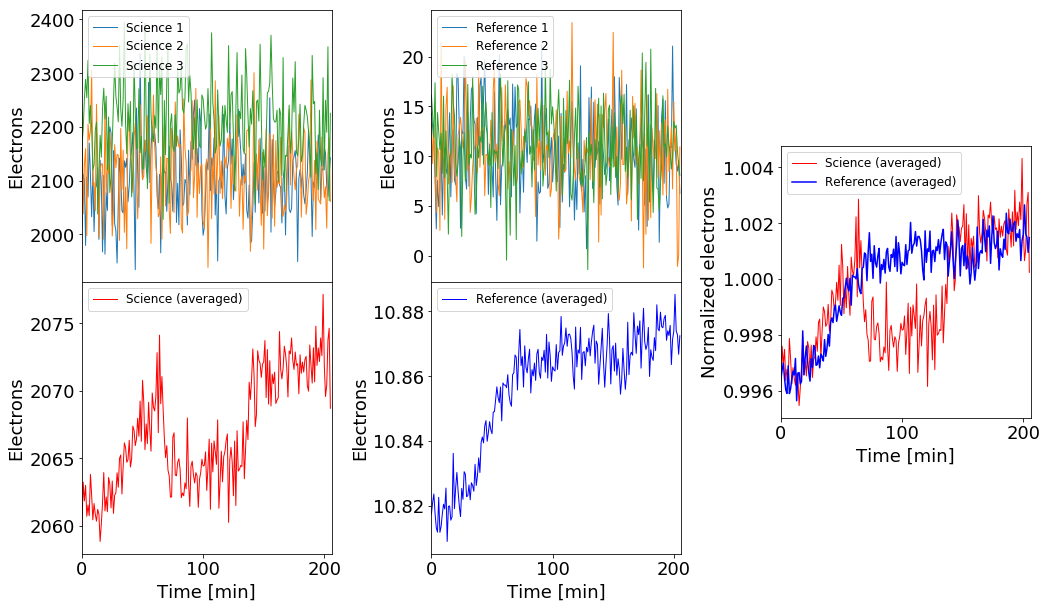

In [21]:
# science pixelとreference pixelで得られるデータのプロット、及びsmooth outの様子を説明したグラフの作成
class SmoothedOut(object):
    
    def __init__(self, i, name, D):
        self.i = i
        self.name = name
        self.D = D
        
    def raw(self):
        plt.subplot(self.i)
        for j in range(3):
            plt.plot(self.D[j], linewidth=1, label='{} {}'.format(self.name, j+1))
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D[0]))
        plt.xticks([])
    
    def binned(self, color):
        plt.subplot(self.i)
        plt.plot(self.D, c=color, linewidth=1, label='{} (averaged)'.format(self.name))
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D))
        
plt.figure(figsize=(17,10))
plt.rcParams['font.size'] = 18
gs = gridspec.GridSpec(4, 3)
SmoothedOut(gs[:2, 0], 'Science', D_sci).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[:2, 1], 'Reference',D_ref).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 0], 'Science', D_sci_mean).binned('r')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 1], 'Reference', D_ref_mean).binned('b')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
plt.subplot(gs[-3:-1, -1])
plt.plot(D_sci_norm, c='r', linewidth=1, label='Science (averaged)')
plt.plot(D_ref_norm, c='b',  label='Reference (averaged)')
plt.legend(loc='upper left', prop={'size':12})
plt.xlim(0, len(D_sci_norm))
plt.xlabel('Time [min]')
plt.ylabel('Normalized electrons')
plt.subplots_adjust(hspace=0, wspace=0.4)

In [103]:
# 補正の前後と入力データを示す図を作成
def Curve(i, ll, x_max, mod, sci, sub):
    ax = fig.add_subplot(i)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.plot(sci[ll], 'ro', c='r', markersize=2)
    ax.plot(sub[ll], 'ro', c='b', markersize=2)
    ax.plot(mod[ll], c='g')
    ax.set_xlim(0, x_max)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Normalized flux')

(0.998, 1.002)

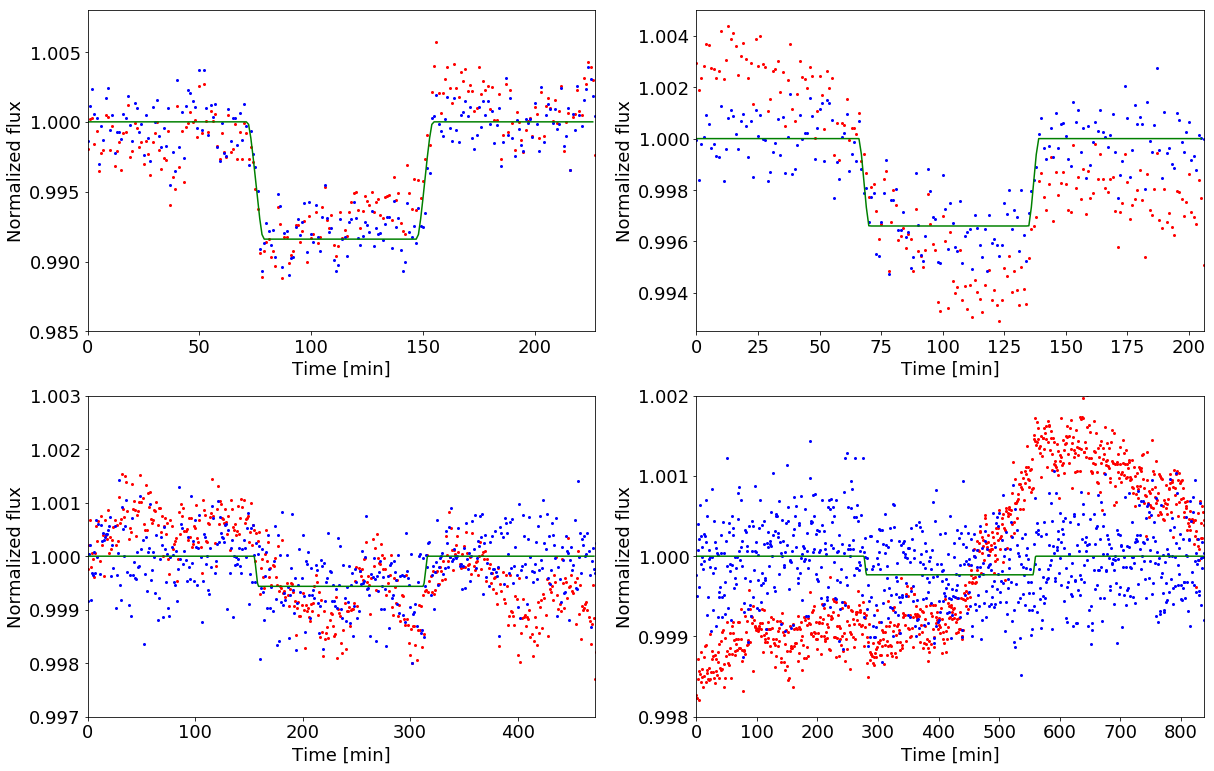

In [23]:
# 生データ
fig = plt.figure(figsize=(20, 13))
plt.rcParams['font.size'] = 18
Curve(221, 66, len(sci_flat_2500[66])/30, mod_2500, sci_flat_2500, sub_flat_2500)
plt.ylim(0.985, 1.008)
Curve(222, 66, len(sci_flat_3000[66])/30, mod_3000, sci_flat_3000, sub_flat_3000)
plt.ylim(0.9925, 1.005)
Curve(223, 66, len(sci_flat_3500[66])/30, mod_3500, sci_flat_3500, sub_flat_3500)
plt.ylim(0.997, 1.003)
Curve(224, 66, len(sci_flat_4000[66])/30, mod_4000, sci_flat_4000, sub_flat_4000)
plt.ylim(0.998, 1.002)

(0.9994, 1.0006)

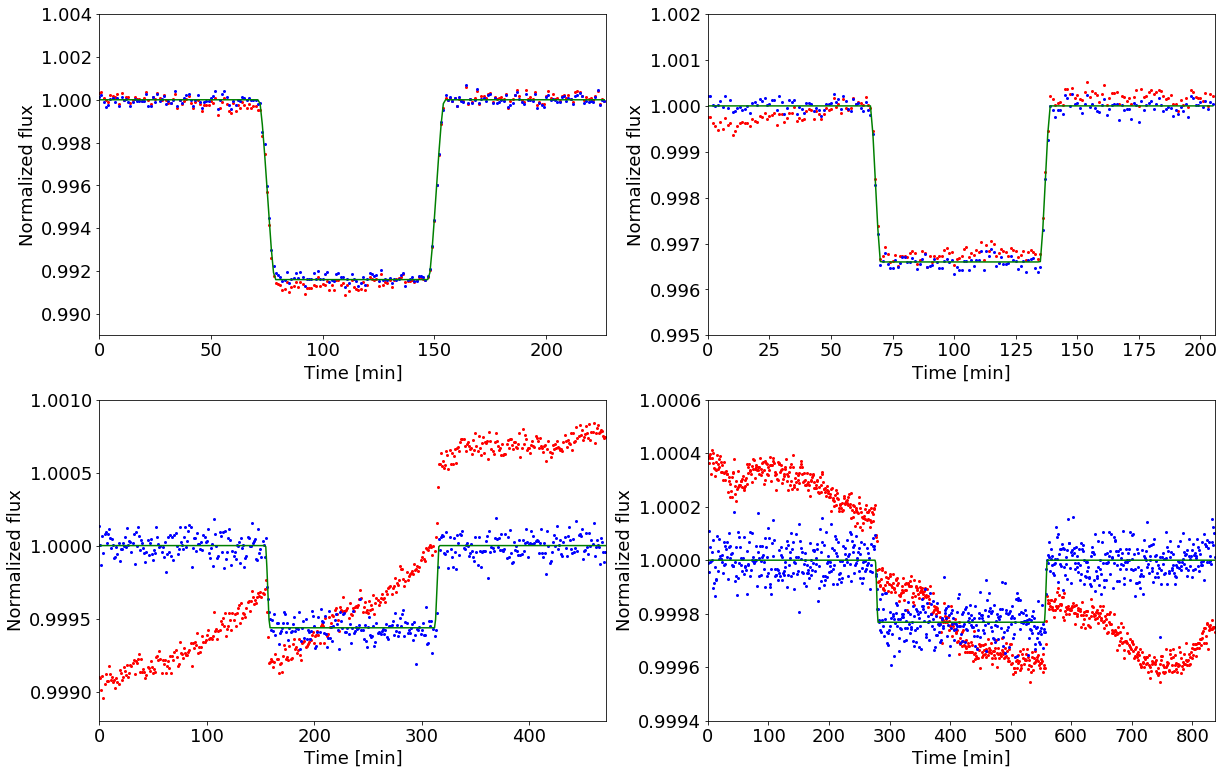

In [816]:
# 60回分のトランジットデータを平均したデータ
fig = plt.figure(figsize=(20, 13))
plt.rcParams['font.size'] = 18
Curve(221, 66, len(sci_bin_2500[66]), mod_2500, sci_bin_2500, sub_bin_2500)
plt.ylim(0.989, 1.004)
Curve(222, 66, len(sci_bin_3000[66]), mod_3000, sci_bin_3000, sub_bin_3000)
plt.ylim(0.995, 1.002)
Curve(223, 66, len(sci_bin_3500[66]), mod_3500, sci_bin_3500, sub_bin_3500)
plt.ylim(0.9988, 1.001)
Curve(224, 66, len(sci_bin_4000[66]), mod_4000, sci_bin_4000, sub_bin_4000)
plt.ylim(0.9994, 1.0006)

In [104]:
# 補正の前後と系統誤差なしの信号のヒストグラム及び真値を示す図を作成
def Histgram(i, ll, mod, sci, sub, wop, y_max):
    ax = fig.add_subplot(i)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.hist(sci[ll], bins=70, color='r', normed=True, alpha=0.6)
    ax.hist(sub[ll], bins=70, color='b', normed=True, alpha=0.6)
    ax.hist(wop[ll], bins=70, color='c', normed=True, alpha=0.6)
    ax.axvline(x=mod[ll, int(len(mod[ll])/2)], color='k')
    ax.axvline(x=mod[ll, 0], color='k')
    ax.set_xlabel('Normalized flux')
    ax.set_ylabel('Count')

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


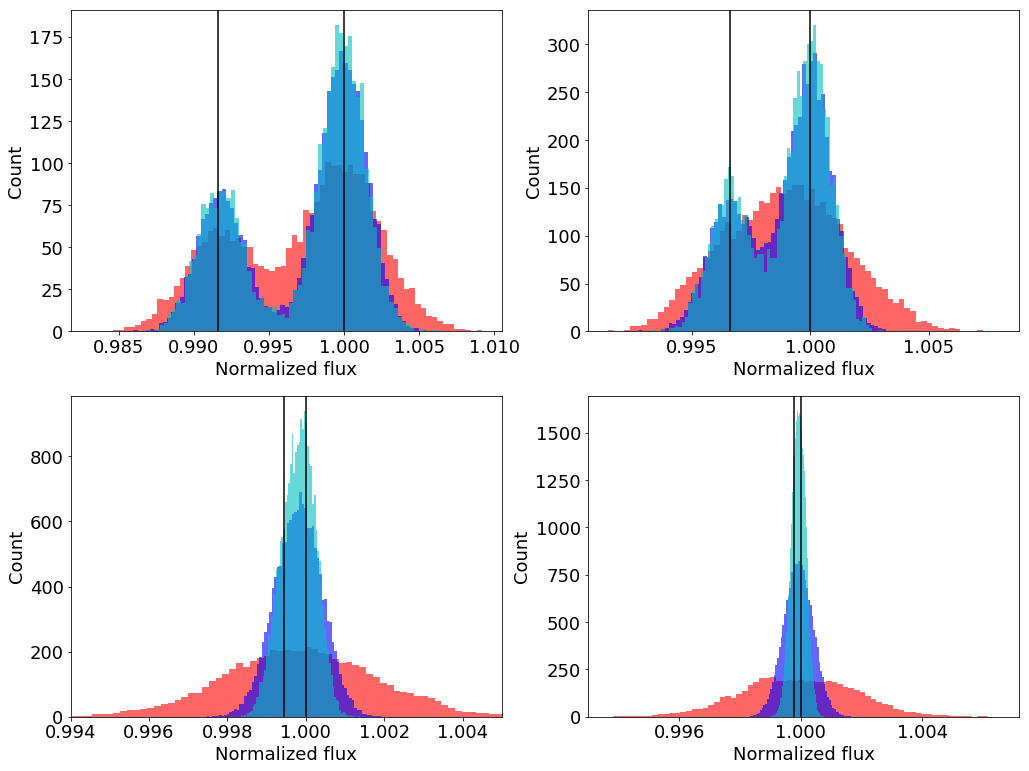

In [818]:
# トランジット60回分のデータ
fig = plt.figure(figsize=(17, 13))
plt.rcParams['font.size'] = 18
Histgram(221, 66, mod_2500, sci_flat_2500, sub_flat_2500, wop_flat_2500, 400)
Histgram(222, 66, mod_3000, sci_flat_3000, sub_flat_3000, wop_flat_3000, 300)
Histgram(223, 66, mod_3500, sci_flat_3500, sub_flat_3500, wop_flat_3500, 600)
plt.xlim(0.994, 1.005)
Histgram(224, 66, mod_4000, sci_flat_4000, sub_flat_4000, wop_flat_4000, 1400)
plt.xticks([0.996, 1, 1.004])
plt.show()

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


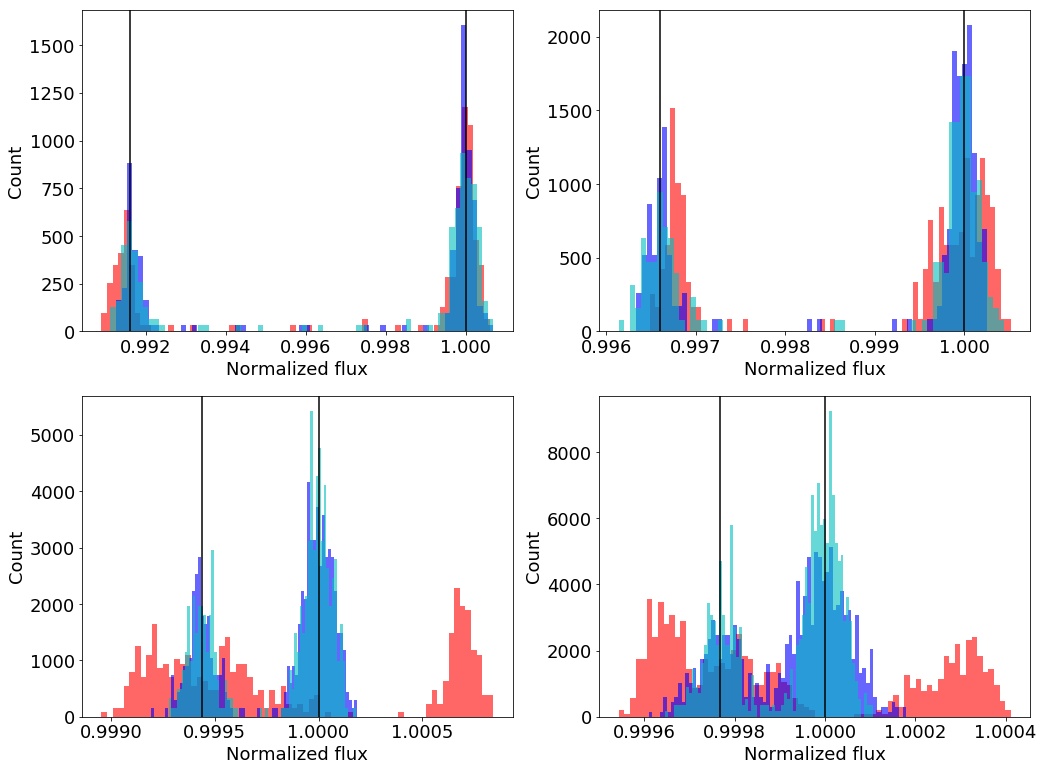

In [819]:
# 30回分のトランジットデータを平均したデータ
fig = plt.figure(figsize=(17, 13))
plt.rcParams['font.size'] = 18
Histgram(221, 66, mod_2500, sci_bin_2500, sub_bin_2500, wop_bin_2500, 400)
Histgram(222, 66, mod_3000, sci_bin_3000, sub_bin_3000, wop_bin_3000, 300)
Histgram(223, 66, mod_3500, sci_bin_3500, sub_bin_3500, wop_bin_3500, 600)
plt.xticks([0.999, 0.9995, 1, 1.0005])
Histgram(224, 66, mod_4000, sci_bin_4000, sub_bin_4000, wop_bin_4000, 1400)
plt.show()

9.987499999999988
20.336248006522563


/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


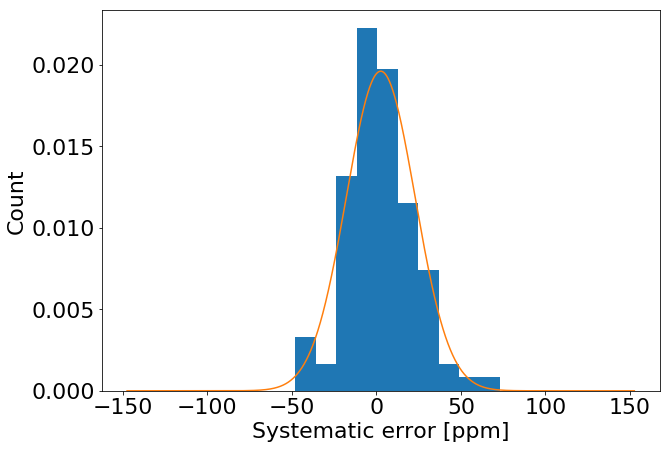

In [146]:
# 100回イテレーションした結果のsystematic errorの分布
def SysHist(eva):
    x = np.linspace(eva.mean()-150, eva.mean()+150, 100000)
    y = np.exp(-(x-eva.mean())**2/(2*eva.std()**2))/(np.sqrt(2*np.pi)*eva.std())
    plt.figure(figsize=(10,7))
    plt.hist(eva, bins=10, normed=True)
    plt.plot(x, y)
    plt.xlabel('Systematic error [ppm]')
    plt.ylabel('Count')
    
λ = 66
print(lamb[λ])
SysHist(sub_eva[:, 1, λ])
print(np.std(sub_eva[:, 1, λ]))

In [345]:
# 系統誤差とランダム誤差を示す図を作成
def Evaluation(i, T, ylim_min, ylim_max):
    plt.subplot(i)
    #plt.plot(lamb, abs(wog_eva_std[T]), 'ro', c='g', markersize=3.0)
    plt.plot(lamb, abs(sci_eva_std[T]), 'ro', c='r', markersize=3.0)
    plt.plot(lamb, abs(sub_eva_std[T]), 'ro', c='b', markersize=3.0)
    plt.plot(lamb, abs(wog_rand[T]), 'x', c='r', markersize=5.0)
    #plt.plot(lamb, abs(sci_rand[T]), 'x', c='r', markersize=5.0)
    plt.plot(lamb, abs(sub_rand[T]), 'x', c='b', markersize=5.0)
    plt.xlabel('Wavelength [μm]')
    plt.ylabel('ppm')
    plt.xlim(lamb[0], lamb[-1])
    plt.ylim(ylim_min, ylim_max)

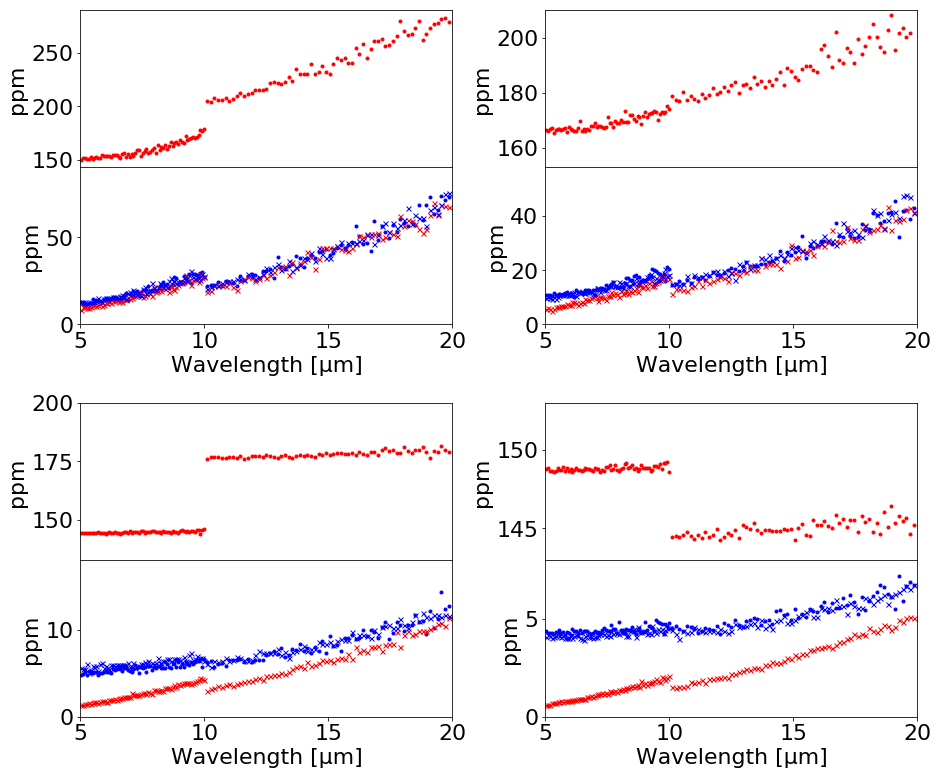

In [53]:
# R=100
plt.figure(figsize=(15, 13))
gs = gridspec.GridSpec(9, 2)
plt.rcParams['font.size'] = 22
Evaluation(gs[0:2, 0], 0, 143, 290)
plt.xticks([])
Evaluation(gs[2:4, 0], 0, 0, 90)
Evaluation(gs[0:2, 1], 1, 153, 210)
plt.xticks([])
Evaluation(gs[2:4, 1], 1, 0, 58)
Evaluation(gs[5:7, 0], 2, 133, 200)
plt.xticks([])
Evaluation(gs[7:9, 0], 2, 0, 18)
Evaluation(gs[5:7, 1], 3, 143, 153)
plt.xticks([])
Evaluation(gs[7:9, 1], 3, 0, 8)
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.show()

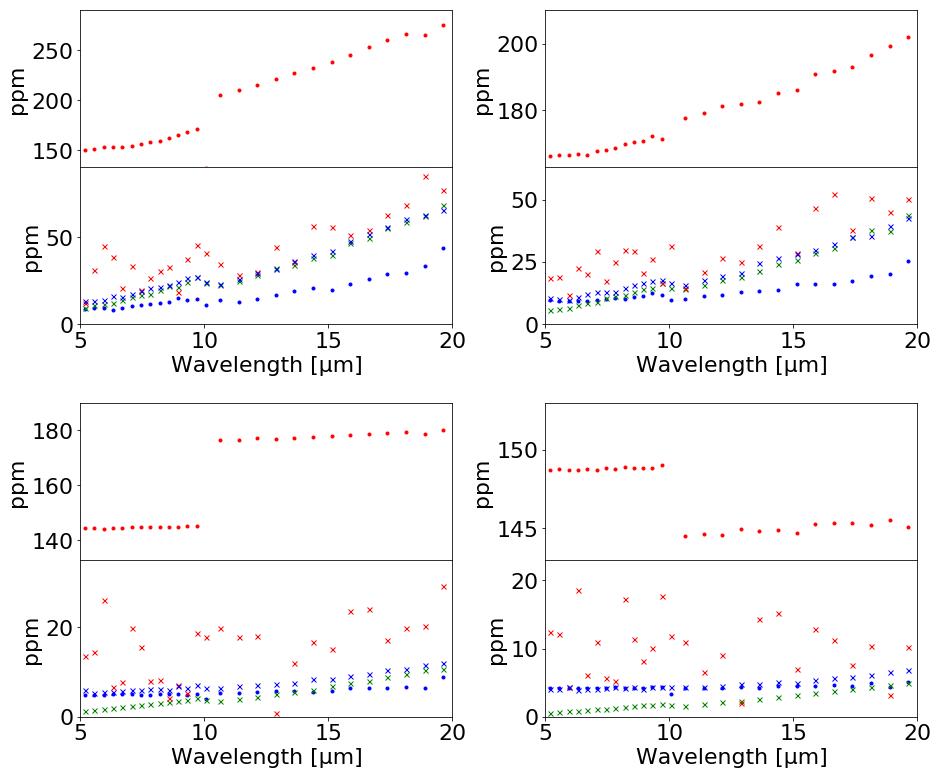

In [136]:
# R=20
plt.figure(figsize=(15, 13))
gs = gridspec.GridSpec(9, 2)
plt.rcParams['font.size'] = 22
Evaluation(gs[0:2, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 0, 133, 290)
plt.xticks([])
Evaluation(gs[2:4, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 0, 0, 90)
Evaluation(gs[0:2, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 1, 163, 210)
plt.xticks([])
Evaluation(gs[2:4, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 1, 0, 63)
Evaluation(gs[5:7, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 2, 133, 190)
plt.xticks([])
Evaluation(gs[7:9, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 2, 0, 35)
Evaluation(gs[5:7, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 3, 143, 153)
plt.xticks([])
Evaluation(gs[7:9, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 3, 0, 23)
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.show()

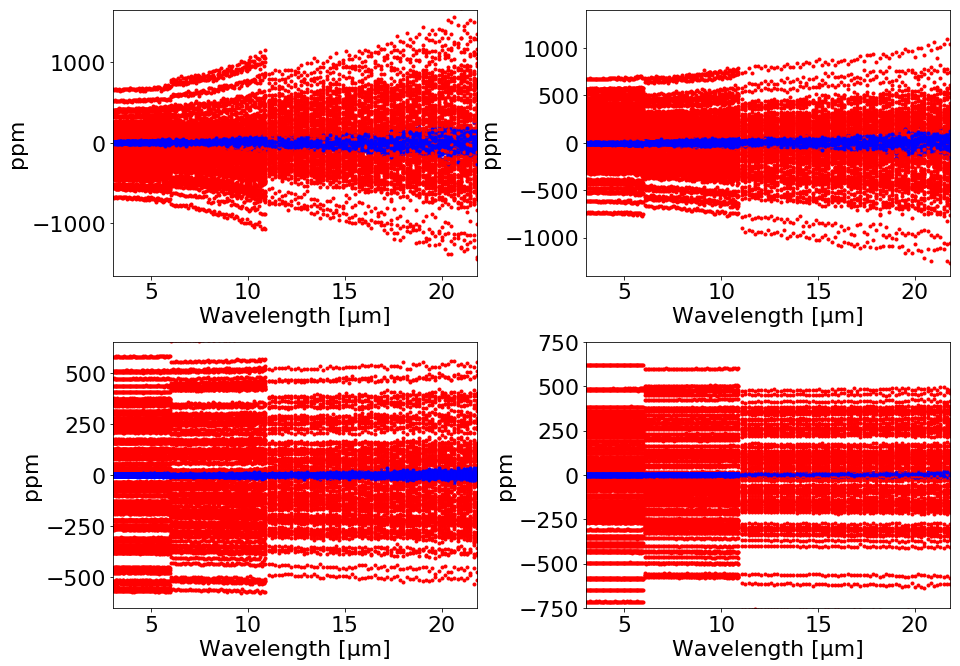

In [366]:
# systematic errorの分布（100回イテレーション）
def SystematicError(i, T, ymax):
    plt.subplot(i)
    for j in range(100):
        plt.plot(lamb, sci_eva[j, T], 'ro', c='r', markersize=3)
        plt.plot(lamb, sub_eva[j, T], 'ro', c='b', markersize=3)
    plt.xlabel('Wavelength [µm]')
    plt.ylabel('ppm')
    plt.xlim(lamb[0], lamb[-1])
    plt.ylim(-ymax, ymax)
    
plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
SystematicError(221, 0, 1650)
SystematicError(222, 1, 1400)
SystematicError(223, 2, 650)
SystematicError(224, 3, 750)
plt.subplots_adjust(hspace=0.25, wspace=0.3)

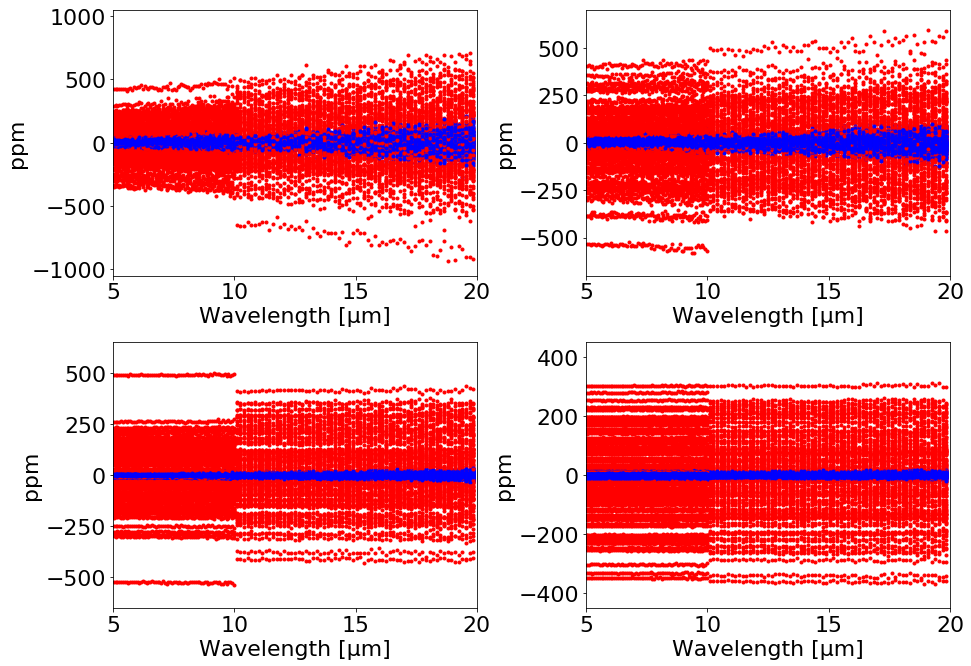

In [139]:
# systematic errorの分布（100回イテレーション）
def SystematicError(i, T, ymax):
    plt.subplot(i)
    for j in range(100):
        plt.plot(lamb, sci_eva[j, T], 'ro', c='r', markersize=3)
        plt.plot(lamb, sub_eva[j, T], 'ro', c='b', markersize=3)
    plt.xlabel('Wavelength [µm]')
    plt.ylabel('ppm')
    plt.xlim(lamb[0], lamb[-1])
    plt.ylim(-ymax, ymax)
    
plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
SystematicError(221, 0, 1050)
SystematicError(222, 1, 700)
SystematicError(223, 2, 650)
SystematicError(224, 3, 450)
plt.subplots_adjust(hspace=0.25, wspace=0.3)

In [141]:
# 地球大気の吸収スペクトルに補正後のデータを載せた図を作成
def Spectrum(i, T, x, y, y_sys, y_err):
    sys_error = y[T]+y_sys[T]
    plt.subplot(i)
    plt.plot(x, y[T], c='r', linewidth = 2.0)
    plt.plot(x, sys_error, 'ro', c='g', markersize=4.0)
    plt.errorbar(x, sys_error, yerr=y_err[T], fmt='ro', markersize=0.0, ecolor='k')
    plt.xlabel('Wavelength [μm]')
    plt.ylabel('Transit depth [ppm]')
    plt.xlim(5, 20)

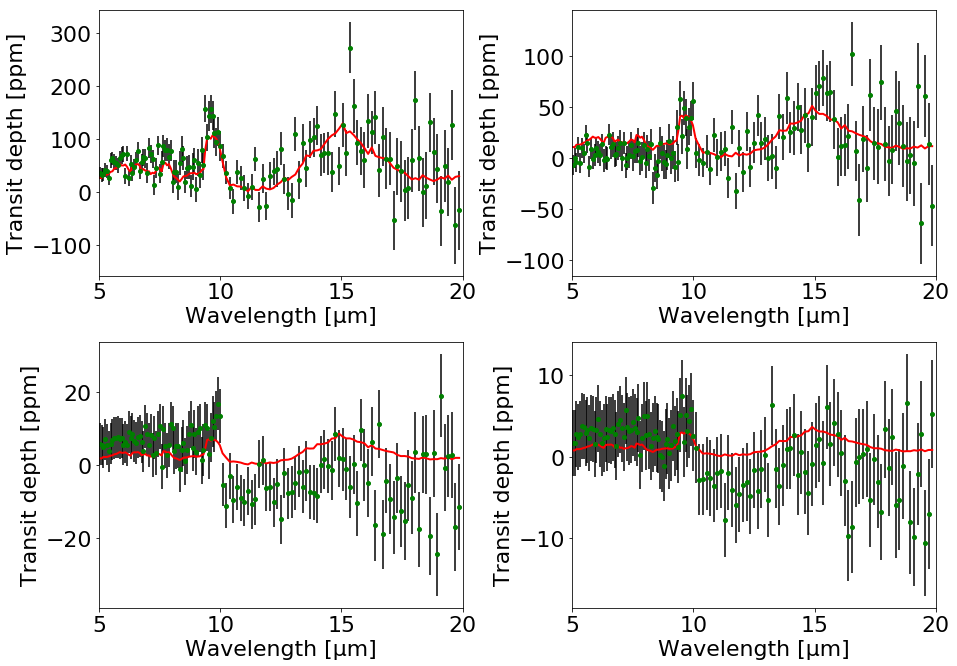

In [148]:
# R=100
plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
rd.seed()
Spectrum(221, 0, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
Spectrum(222, 1, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
Spectrum(223, 2, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
Spectrum(224, 3, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.show()

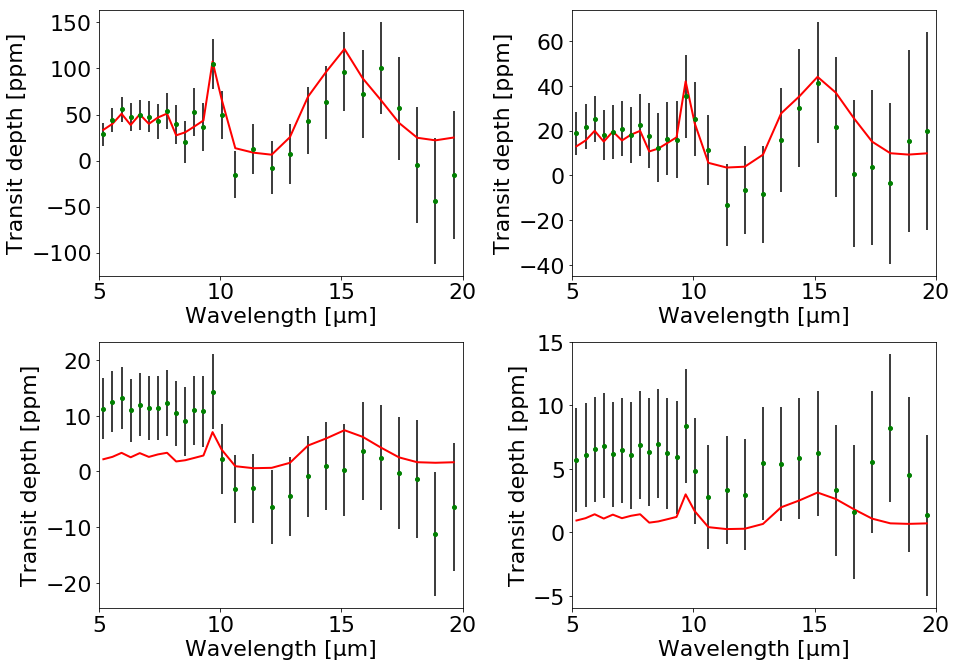

In [144]:
# R=20
plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
Spectrum(221, 0, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
Spectrum(222, 1, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
Spectrum(223, 2, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
Spectrum(224, 3, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.show()